In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/datasets and others/dccc_prepared.csv")
data.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
1,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
2,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
3,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,0.203506,0.120381,0.117974,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513,0
4,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,0.472126,0.457242,0.330672,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047,0


In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [ ]:
X_new, X_test, y_new, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new,y_new,test_size = dev_per, random_state = 0)


In [ ]:
X_dev_torch = torch.tensor(X_dev.values).float()
y_dev_torch = torch.tensor(y_dev.values)
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values)


In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 100)
        self.hidden_2 = nn.Linear(100, 100)
        self.hidden_3 = nn.Linear(100, 50)
        self.hidden_4 = nn.Linear(50,50)
        self.output = nn.Linear(50, 2)
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        z = self.dropout(F.relu(self.hidden_1(x)))
        z = self.dropout(F.relu(self.hidden_2(z)))
        z = self.dropout(F.relu(self.hidden_3(z)))
        z = self.dropout(F.relu(self.hidden_4(z)))
        out = F.log_softmax(self.output(z), dim=1)
        return out

In [ ]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 400
batch_size = 128


In [ ]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []
for e in range(1, epochs + 1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ps = torch.exp(pred)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
    dev_loss = 0
    acc = 0
    with torch.no_grad():
        model.eval()
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)
        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)
    model.train()
    if e%10 == 0 or e == 1:
        x_axis.append(e)
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)
        print("Epoch: {}/{}.. ".format(e, epochs), 
              "Training Loss: {:.3f}.. ".format(running_loss/iterations), 
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations), 
              "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/400..  Training Loss: 0.619..  Validation Loss: 0.607..  Training Accuracy: 0.657..  Validation Accuracy: 0.665
Epoch: 10/400..  Training Loss: 0.561..  Validation Loss: 0.562..  Training Accuracy: 0.712..  Validation Accuracy: 0.711
Epoch: 20/400..  Training Loss: 0.551..  Validation Loss: 0.555..  Training Accuracy: 0.717..  Validation Accuracy: 0.712
Epoch: 30/400..  Training Loss: 0.541..  Validation Loss: 0.554..  Training Accuracy: 0.725..  Validation Accuracy: 0.718
Epoch: 40/400..  Training Loss: 0.533..  Validation Loss: 0.549..  Training Accuracy: 0.731..  Validation Accuracy: 0.717
Epoch: 50/400..  Training Loss: 0.525..  Validation Loss: 0.545..  Training Accuracy: 0.737..  Validation Accuracy: 0.720
Epoch: 60/400..  Training Loss: 0.516..  Validation Loss: 0.541..  Training Accuracy: 0.744..  Validation Accuracy: 0.726
Epoch: 70/400..  Training Loss: 0.510..  Validation Loss: 0.537..  Training Accuracy: 0.748..  Validation Accuracy: 0.730
Epoch: 80/400..  Training

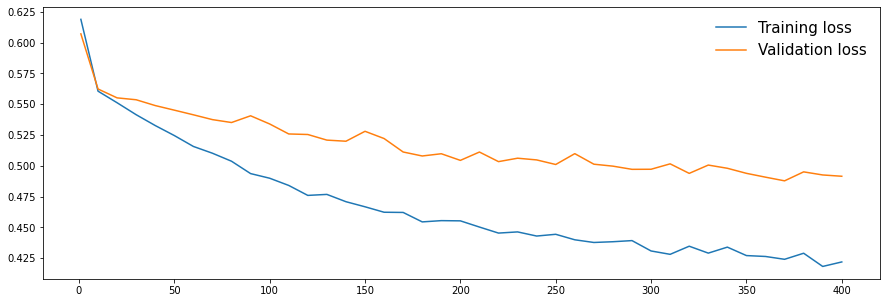

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False , fontsize=15)
plt.show()

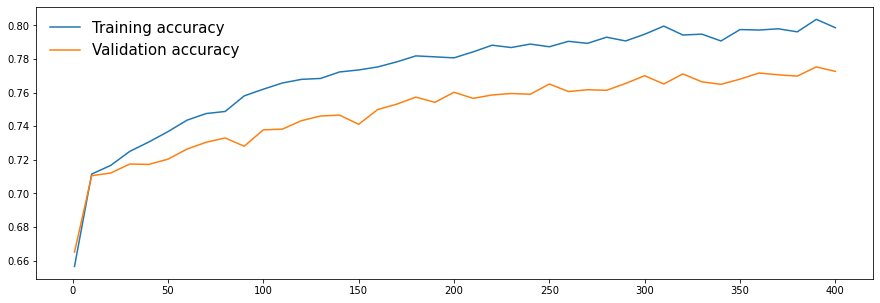

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False , fontsize=15)
plt.show()

In [ ]:
model.eval()
test_pred = model(X_test_torch)
test_pred = torch.exp(test_pred)
top_p, top_class_test = test_pred.topk(1, dim=1)
acc_test = accuracy_score(y_test_torch, top_class_test)
print(acc_test)

0.7756259362294029
